# LSH Improvement Testing 

This file will be used to test our first LSH improvements, multi probe lookup. 

We using this [paper](https://www.sciencedirect.com/science/article/pii/S0165168412002447) as reference for the multi probe improvements.

In [1]:
import hashlib
import re
from collections import defaultdict
from itertools import combinations
from utils.utils import clean_document, shingle, minhash
import numpy as np
from joblib import Parallel, delayed
import time
import pandas as pd

The main part of the improvement is the perturbation of the hash key. So, here are additional methods we could aslo use (I'll need to test these out)

In [2]:
# This is simply a bit-wise perturbation
# def bit_flip(self, band, num_probes):
#     perturbed_bands = []

#     #flipping the bits in the hash 
#     for _ in range(num_probes):
#         p_band = list(band)
#         i = np.random.randint(0, len(p_band)) 
#         p_band[i] ^= 1  # Flip a bit at the random index
#         perturbed_bands.append(tuple(p_band))

#     return perturbed_bands

In [3]:
# Gaussian perturbation can help for close hashs (near duplicates)
# def gaussian(self, band, num_probes, std_dev=1.0):
#     perturbed_bands = []

#     #adding gaussian "noise" so that hash is slightly altered
#     for _ in range(num_probes):
#         p_band = list(band)
#         i = np.random.randint(0, len(p_band))
#         noise = np.random.normal(0, std_dev)  # adding Gaussian noise
#         p_band[i] += noise
#         perturbed_bands.append(tuple(p_band))

#     return perturbed_bands

Keeping track of versions: 


- Basic LSH on my computer: 

    - 2024-10-17 22:00:03,637 - INFO - **MinHash computation time: 44.05 seconds**

    - 2024-10-17 22:00:03,678 - INFO - **LSH banding time: 0.04 seconds**

    - 2024-10-17 22:00:03,680 - INFO - Input Documents: 100

    - 2024-10-17 22:00:03,681 - INFO - Unique Documents: 82

    - 2024-10-17 22:00:03,681 - INFO - Clusters Formed: 61

- % Nearby Hashing 

    - 2024-10-17 22:02:41,504 - INFO - **MinHash computation time: 58.06 seconds**

    - 2024-10-17 22:02:41,604 - INFO - **LSH banding time: 0.10 seconds**


    - 2024-10-17 22:02:41,605 - INFO - Input Documents: 100

    - 2024-10-17 22:02:41,606 - INFO - Unique Documents: 82

    - 2024-10-17 22:02:41,606 - INFO - Clusters Formed: 61

- Bit-wise Hashing 
    
    - 2024-10-17 22:07:11,360 - INFO - **MinHash computation time: 46.05 seconds**

    - 2024-10-17 22:07:11,437 - INFO - **LSH banding time: 0.08 seconds**

    - 2024-10-17 22:07:11,437 - INFO - Input Documents: 100

    - 2024-10-17 22:07:11,438 - INFO - Unique Documents: 82

    - 2024-10-17 22:07:11,438 - INFO - Clusters Formed: 61

- Gaussian 

    - 2024-10-17 22:12:15,491 - INFO - **MinHash computation time: 50.54 seconds**

    - 2024-10-17 22:12:15,611 - INFO - **LSH banding time: 0.12 seconds**

    - 2024-10-17 22:12:15,612 - INFO - Input Documents: 100

    - 2024-10-17 22:12:15,612 - INFO - Unique Documents: 82

    - 2024-10-17 22:12:15,612 - INFO - Clusters Formed: 61

In [4]:
class LSHImproved:
    """Multi Probe Locality Sensitive Hashing with MinHash and Banding."""
    def __init__(self, num_hashes=100, num_bands=20, rows_per_band=5, k=5, num_probes = 4, banding_method='nearby_banding'):
        self.num_hashes = num_hashes
        self.num_bands = num_bands
        self.rows_per_band = rows_per_band
        self.num_probes = num_probes #Initializing the number of probes 
        self.index = defaultdict(list)
        self.unique_docs = {}
        self.cleaned_docs = {}
        self.candidate_pairs = set()
        self.exact_duplicates = {}
        self.banding_method = banding_method

        self.k = k
        assert self.num_hashes == self.num_bands * self.rows_per_band, "Hash functions must equal bands * rows_per_band"
    
    # Keeping remove duplicates the same
    def remove_duplicates(self, docs):
        seen_docs = {}
        for doc_id, doc in docs.items():
            if doc not in seen_docs:
                self.unique_docs[doc_id] = doc
                seen_docs[doc] = doc_id  # Track first occurrence of the document
            else:
                # Track exact duplicates
                original_id = seen_docs[doc]
                if original_id not in self.exact_duplicates:
                    self.exact_duplicates[original_id] = []
                self.exact_duplicates[original_id].append(doc_id)


    def compute_minhash_signatures(self, docs):
        """Compute MinHash signatures for each document in parallel."""
        self.remove_duplicates(docs)
        self.cleaned_docs = {doc_id: clean_document(doc) for doc_id, doc in self.unique_docs.items()}
        self.shingle_sets = {doc_id: shingle(doc, self.k) for doc_id, doc in self.cleaned_docs.items()}
        
        # Parallel computation of MinHash signatures
        signatures = Parallel(n_jobs=-1)( delayed(minhash)(shingles, self.num_hashes) for doc_id, shingles in self.shingle_sets.items())
        self.signatures = dict(zip(self.shingle_sets.keys(), signatures))

        return self.signatures
    

    #Minhash will also remain the same
    # def compute_minhash_signatures(self, docs):
    #     """Compute MinHash signatures for each document."""
    #     self.remove_duplicates(docs)
    #     self.cleaned_docs = {doc_id: clean_document(doc) for doc_id, doc in self.unique_docs.items()}

    #     self.shingle_sets = {doc_id: shingle(doc, self.k) for doc_id, doc in self.cleaned_docs.items()}
    #     self.signatures = {doc_id: minhash(shingles, self.num_hashes) for doc_id, shingles in self.shingle_sets.items()}

    #     return self.signatures
    
    # Creating nearby_banding
    def nearby_banding(self, band, num_probes):
        # We identify "nearby" neighbors by making perturbations in the hash key
        perturbed_bands = []

        for _ in range(num_probes):
            changed_band = list(band)

            #picking random band to change
            i = np.random.randint(0, len(changed_band))
            changed_band[i] = (changed_band[i] + np.random.randint(1, 10)) % 100 
            # ^^ used modules perturbation in this case, but there other options we can change

            #appending to list 
            perturbed_bands.append(tuple(changed_band))
        
        return perturbed_bands

    def bit_flip(self, band, num_probes):
        perturbed_bands = []

        #flipping the bits in the hash 
        for _ in range(num_probes):
            p_band = list(band)
            i = np.random.randint(0, len(p_band)) 
            p_band[i] ^= 1  # Flip a bit at the random index
            perturbed_bands.append(tuple(p_band))

        return perturbed_bands
    
    def gaussian(self, band, num_probes, std_dev=1.0):
        perturbed_bands = []

        #adding gaussian "noise" so that hash is slightly altered
        for _ in range(num_probes):
            p_band = list(band)
            i = np.random.randint(0, len(p_band))
            noise = np.random.normal(0, std_dev)  # adding Gaussian noise
            p_band[i] += noise
            perturbed_bands.append(tuple(p_band))

        return perturbed_bands

    #Changing the banding method so it checks neighboring bands
    def banding(self, signatures):
        if self.banding_method == 'nearby_banding':
            perturb_fn = self.nearby_banding
        elif self.banding_method == 'bit_flip':
            perturb_fn = self.bit_flip
        elif self.banding_method == 'gaussian':
            perturb_fn = lambda band, num_probes: self.gaussian(band, num_probes)
        else:
            raise ValueError(f"Unknown banding method: {self.banding_method}")

        # Process signatures and apply perturbations
        for doc_id, sig in signatures.items():
            for band_idx in range(self.num_bands):
                start = band_idx * self.rows_per_band
                band = tuple(sig[start:start + self.rows_per_band])
                self.index[(band_idx, band)].append(doc_id)

                neighboring_bands = perturb_fn(band, self.num_probes)
                for neighbor in neighboring_bands:
                    self.index[(band_idx, neighbor)].append(doc_id)

        for doc_ids in self.index.values():
            if len(doc_ids) > 1:
                self.candidate_pairs.update(combinations(doc_ids, 2))

        return self.candidate_pairs

In [5]:
from utils.use_cases import collection_deduplication, nearest_neighbor_search
from utils.utils import read_tsv

In [14]:
docs = {
    1: "the quick brown fox jumps over the lazy dog",
    2: "the quick brown fox jumped over the lazy dog",
    3: "apples are really yummy in apple pie",
    4: "the lazy dog jumps over the quick brown fox",
}

tsv_dict = read_tsv('../../data/hundred.tsv')

strategies = ['nearby_banding', 'bit_flip', 'gaussian']
probe_values = [3, 4, 5]
results = []

for strategy in strategies:
    for num_probes in probe_values:
        # Initialize LSHImproved with strategy and num_probes
        lsh = LSHImproved(num_hashes=100, num_bands=20, rows_per_band=5, num_probes=num_probes, banding_method= strategy)

        # Run deduplication and measure time
        start_time = time.time()
        signatures = lsh.compute_minhash_signatures(tsv_dict)
        candidate_pairs = lsh.banding(signatures)
        clusters = collection_deduplication(lsh)
        end_time = time.time()
        
        # Calculate execution time and store results
        execution_time = end_time - start_time
        results.append({
            'Strategy': strategy,
            'Num_Probes': num_probes,
            'Execution_Time': execution_time,
            'Num_Clusters': len(clusters),
            'Clusters': clusters
        })


results_df = pd.DataFrame(results)
results_df.to_csv("lsh_experiment_results.csv", index=False)
results_df.head()

,Strategy,Num_Probes,Execution_Time,Num_Clusters,Clusters
0,nearby_banding,3,38.377106,61,"{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6..."
1,nearby_banding,4,30.310824,61,"{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6..."
2,nearby_banding,5,34.398176,60,"{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6..."
3,bit_flip,3,31.747555,61,"{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6..."
4,bit_flip,4,32.619252,61,"{1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6..."


In [15]:
results_df.dtypes

Strategy           object
Num_Probes          int64
Execution_Time    float64
Num_Clusters        int64
Clusters           object
dtype: object

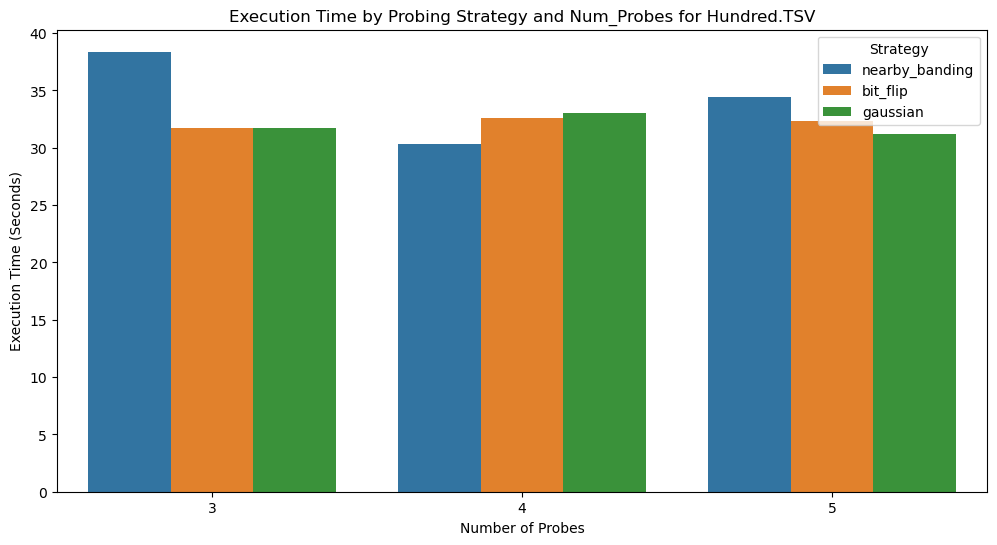

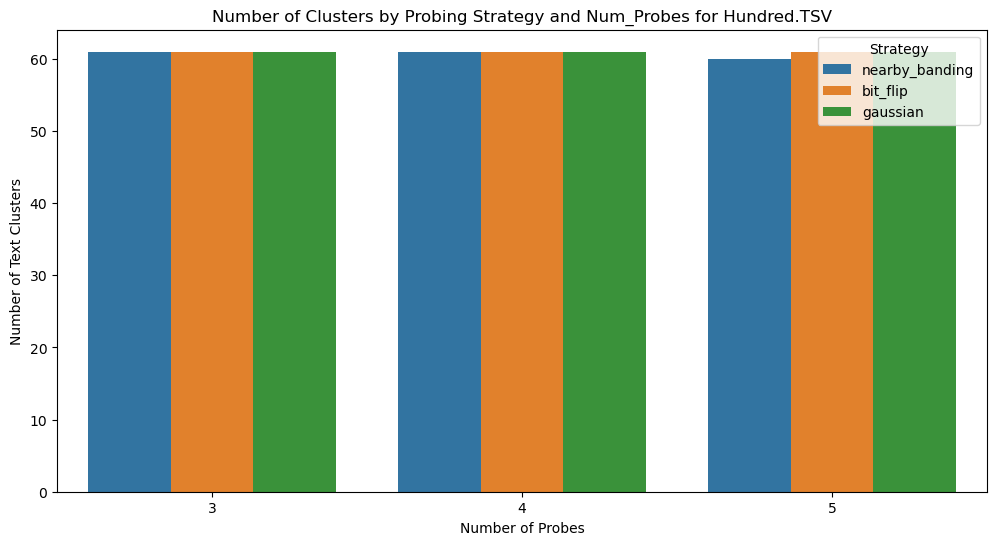

In [20]:
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results_df.drop(columns=['Clusters'])
plot_df
# Load results
# results_df = pd.read_csv("lsh_experiment_results.csv")

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='Num_Probes', y='Execution_Time', hue='Strategy')
plt.title("Execution Time by Probing Strategy and Num_Probes for Hundred.TSV")
plt.ylabel("Execution Time (Seconds)")
plt.xlabel("Number of Probes")
plt.show()

# Plot number of clusters
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Num_Probes', y='Num_Clusters', hue='Strategy')
plt.title("Number of Clusters by Probing Strategy and Num_Probes for Hundred.TSV")
plt.ylabel("Number of Text Clusters")
plt.xlabel("Number of Probes")
plt.show()

From testing with the hundred.tsv file, we can see that the process that is both the fastest and provides the a good amount of clusters is nearby_banding with 4 probes. We will set that as the default. 